# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных:
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

Дополнительные условия:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и просмотр данных

Загрузим датасеты, сохраним их в датафреймы и изучим общую информацию о данных.

In [1]:
# Подключение всех необходимых библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка pandas для отображения полного текста
pd.set_option('display.max_colwidth', None)

# Задаем стиль графиков
sns.set(style="whitegrid")

# ML
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Загружает CSV-файл и выводит случайные строки и общую информацию
def load_and_inspect_csv(filepath, delimiter=',', sample_size=5):
    if os.path.exists(filepath):
        df = pd.read_csv(filepath, delimiter=delimiter)
        print(f"Файл успешно загружен: {filepath}")
        display(df.sample(sample_size, random_state=42))
        df.info()
        return df
    else:
        print(f"Файл не найден: {filepath}")
        return None

In [3]:
# Первый регион
geo_data_0 = load_and_inspect_csv('/datasets/geo_data_0.csv')

Файл успешно загружен: /datasets/geo_data_0.csv


,id,f0,f1,f2,product
75721,7C6bA,0.599283,-0.557623,2.121187,122.073350
80184,dVxsn,0.739017,-0.463156,-1.347584,48.738540
19864,1Gm3l,1.422743,-0.534917,3.718798,131.338088
76699,Nzg1t,1.580244,-0.238458,2.805149,88.327757
92991,Z7b4F,0.918974,0.023961,2.598575,36.959266


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
# Второй регион
geo_data_1 = load_and_inspect_csv('/datasets/geo_data_1.csv')

Файл успешно загружен: /datasets/geo_data_1.csv


,id,f0,f1,f2,product
75721,fYVDK,6.078076,0.084568,0.002957,0.000000
80184,3SQcq,16.462386,2.712946,1.993030,53.906522
19864,hQ1gJ,7.051898,0.766983,4.990194,134.766305
76699,Y4vux,-0.240045,-0.380804,3.999693,107.813044
92991,H1NUw,13.350111,-8.558281,0.002010,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
# Третий регион
geo_data_2 = load_and_inspect_csv('/datasets/geo_data_2.csv')

Файл успешно загружен: /datasets/geo_data_2.csv


,id,f0,f1,f2,product
75721,sPjbT,2.111118,-1.679773,3.112240,117.441301
80184,1u4uo,0.734759,0.747788,3.670879,47.841249
19864,kZ6HO,-2.513109,0.844631,-4.922889,45.883483
76699,gCZGK,-2.035301,-1.522988,5.072839,139.014608
92991,rqJHx,2.744145,1.429952,-1.372661,84.004276


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Все три датасета содержат по 100 000 строк и 5 столбцов: уникальный идентификатор скважины (`id`), три числовых признака (`f0`, `f1`, `f2`) и целевую переменную (`product`), выраженную в тысячах баррелей. Пропущенные значения отсутствуют, типы данных корректны: признаки представлены как `float64`, идентификаторы – как `object`. Перед обучением модели необходимо проверить наличие полных дубликатов строк и дубликатов по столбцу `id`.

## Предобработка данных

Работу со стобцами выполнять не нужно - названия уже в змеином формате, типы данных корректны.

Хоть мы и заметили, что пропусков нет, убедимся в этом явно.

In [6]:
# Определяет пропущенные значения и выводит строки с ними
def analyze_missing_values(df):
    missing_counts = df.isna().sum()
    missing_counts = missing_counts[missing_counts > 0]
    
    if missing_counts.empty:
        print("Пропущенные значения отсутствуют.")
    else:
        print("Число пропусков по столбцам:")
        display(missing_counts)
        print("\nСтроки с пропущенными значениями:")
        display(df[df.isna().any(axis=1)])

In [7]:
for df in [geo_data_0, geo_data_1, geo_data_2]:
    analyze_missing_values(df)

Пропущенные значения отсутствуют.
Пропущенные значения отсутствуют.
Пропущенные значения отсутствуют.


Теперь проверим дубли.

In [8]:
def analyze_duplicates(df, subset=None):
    # Маска дубликатов (все, кроме первого вхождения)
    duplicate_mask = df.duplicated(subset=subset, keep='first')
    
    if not duplicate_mask.any():
        print("Дубликаты отсутствуют.")
        return
    
    col_info = f"по столбцам: {subset}" if subset else "по всем столбцам"
    print(f"Найдено дубликатов ({col_info}): {duplicate_mask.sum()}")

    # Получаем все строки-дубликаты и их первые оригиналы
    duplicates = df[duplicate_mask]
    first_occurrences = df[df.duplicated(subset=subset, keep='last')]

    # Объединяем для сравнения
    combined = pd.concat([first_occurrences, duplicates]).sort_index()
    
    display(combined)

In [9]:
# Первый регион
# Проверка на полные дубликаты по всем признакам
analyze_duplicates(geo_data_0)

# Проверка на дубликаты по id
analyze_duplicates(geo_data_0, subset=["id"])

Дубликаты отсутствуют.
Найдено дубликатов (по столбцам: ['id']): 10


,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


In [10]:
# Второй регион
# Проверка на полные дубликаты по всем признакам
analyze_duplicates(geo_data_1)

# Проверка на дубликаты по id
analyze_duplicates(geo_data_1, subset=["id"])

Дубликаты отсутствуют.
Найдено дубликатов (по столбцам: ['id']): 4


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [11]:
# Третий регион
# Проверка на полные дубликаты по всем признакам
analyze_duplicates(geo_data_2)

# Проверка на дубликаты по id
analyze_duplicates(geo_data_2, subset=["id"])

Дубликаты отсутствуют.
Найдено дубликатов (по столбцам: ['id']): 4


,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Во всех трёх датасетах отсутствуют полные дубликаты строк. Однако были обнаружены дублирующиеся значения в столбце `id`: 10 в регионе 1, 4 в регионе 2 и 4 в регионе 3. При этом строки с одинаковыми `id` отличаются по признакам и целевой переменной, что исключает возможность их удаления как дубликатов. Поскольку столбец `id` не используется при моделировании и анализе признаков, он сохраняется в исходном виде. Это позволит при необходимости идентифицировать скважины после завершения анализа.

## Исследовательский анализ данных

### Распределения признаков

Проведем EDA - исследуем все признаки и сделаем выводы о том, как их нужно подготовить.

In [12]:
# Универсальная функция для первичного EDA
def explore_dataframe(df, name):
    print(f'--- Анализ таблицы: {name} ---\n')

    # Исключаем id из анализа
    df = df.drop(columns=['id'], errors='ignore')

    # Разделение признаков
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    discrete_cols = [
        col for col in numeric_cols
        if pd.api.types.is_integer_dtype(df[col]) and df[col].nunique() <= 20
    ]
    continuous_cols = [col for col in numeric_cols if col not in discrete_cols]

    # Числовые признаки
    print('Числовые признаки:\n')
    display(df[numeric_cols].describe().T)
    print()

    # Категориальные признаки
    if categorical_cols:
        print('Категориальные признаки:\n')
        cat_stats = []
        for col in categorical_cols:
            mode_val = df[col].mode()[0] if not df[col].mode().empty else None
            cat_stats.append({
                'Признак': col,
                'Уникальных значений': df[col].nunique(),
                'Мода': mode_val
            })
        display(pd.DataFrame(cat_stats))
        print()

    # Построение графиков
    def plot_distributions(cols, plot_type, title):
        n = len(cols)
        cols_per_row = 2
        rows = (n + cols_per_row - 1) // cols_per_row
        fig, axes = plt.subplots(rows, cols_per_row, figsize=(14, 5 * rows))
        axes = axes.flatten()

        for i, col in enumerate(cols):
            if plot_type == 'numeric':
                sns.histplot(df[col], kde=True, ax=axes[i])
            else:
                sns.countplot(data=df, x=col, ax=axes[i], order=df[col].value_counts().index)
                axes[i].tick_params(axis='x', rotation=45)
            axes[i].set_title(col)

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        fig.suptitle(f'{title} ({name})', fontsize=16)
        plt.tight_layout()
        plt.show()

    if continuous_cols:
        plot_distributions(continuous_cols, 'numeric', 'Распределение непрерывных числовых признаков')

    if discrete_cols or categorical_cols:
        plot_distributions(discrete_cols + categorical_cols, 'categorical', 'Распределение дискретных и категориальных признаков')

--- Анализ таблицы: First region ---

Числовые признаки:



,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


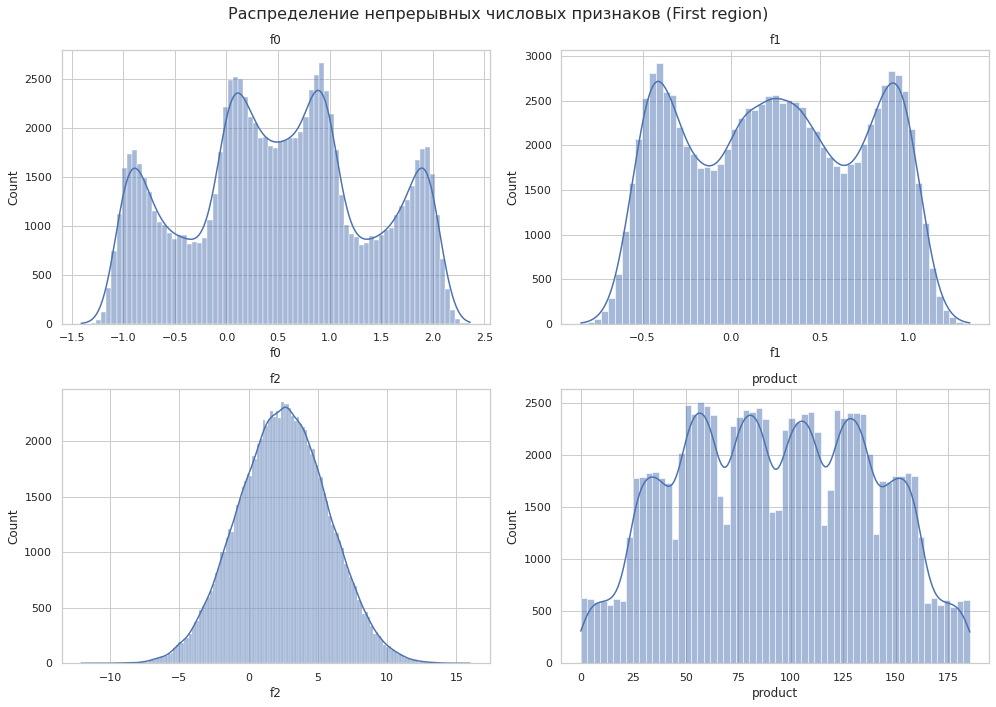

In [13]:
# Первый регион 
explore_dataframe(geo_data_0, "First region")

Распределения признаков `f0` и `f1` имеют выраженную многомодальную структуру и находятся в пределах ограниченного диапазона. Признак `f2` распределён близко к нормальному, но с длинными хвостами. Целевая переменная `product` демонстрирует многомодальность и равномерное распределение по всему диапазону, что может быть результатом синтетической генерации. Среднее значение объёма запасов составляет 92.5 тыс. баррелей, разброс умеренный.

--- Анализ таблицы: Second region ---

Числовые признаки:



,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


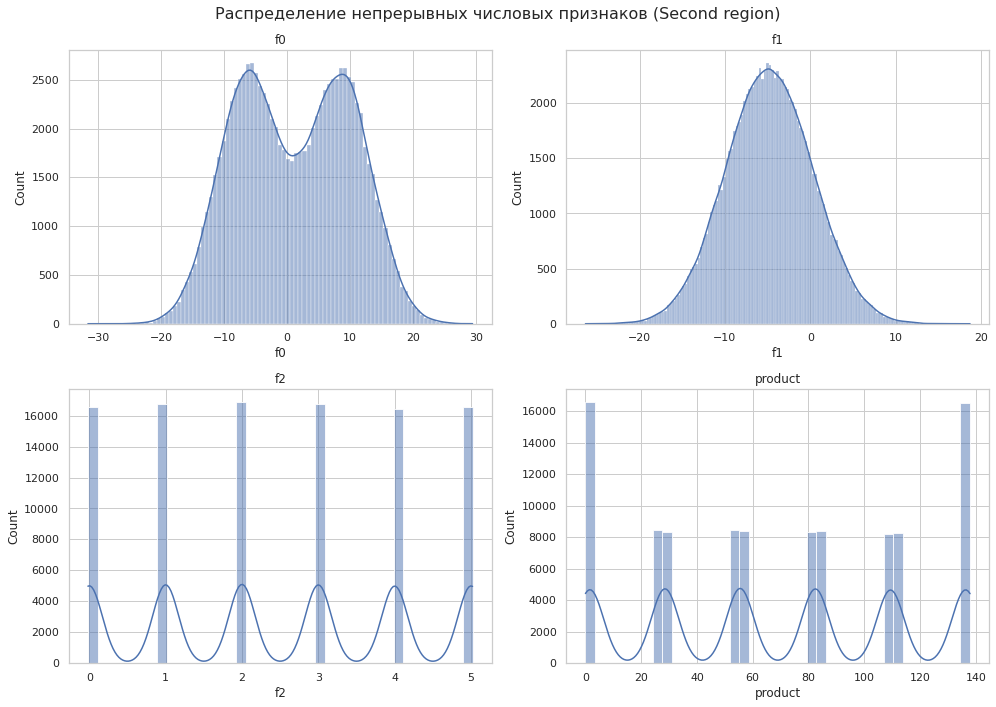

In [14]:
# Второй регион 
explore_dataframe(geo_data_1, "Second region")

Распределения признаков в данном регионе наиболее нестабильны: `f0` и `f1` имеют значительно растянутые значения (от -30 до +30), а `f2` принимает ограниченное число фиксированных значений, что указывает на его дискретную природу. Распределение целевой переменной `product` также носит искусственный характер – значения разбиты на отдельные группы с явно выраженными пиками. Среднее значение объёма запасов ниже, чем в других регионах, и составляет около 68.8 тыс. баррелей.

--- Анализ таблицы: Third region ---

Числовые признаки:



,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


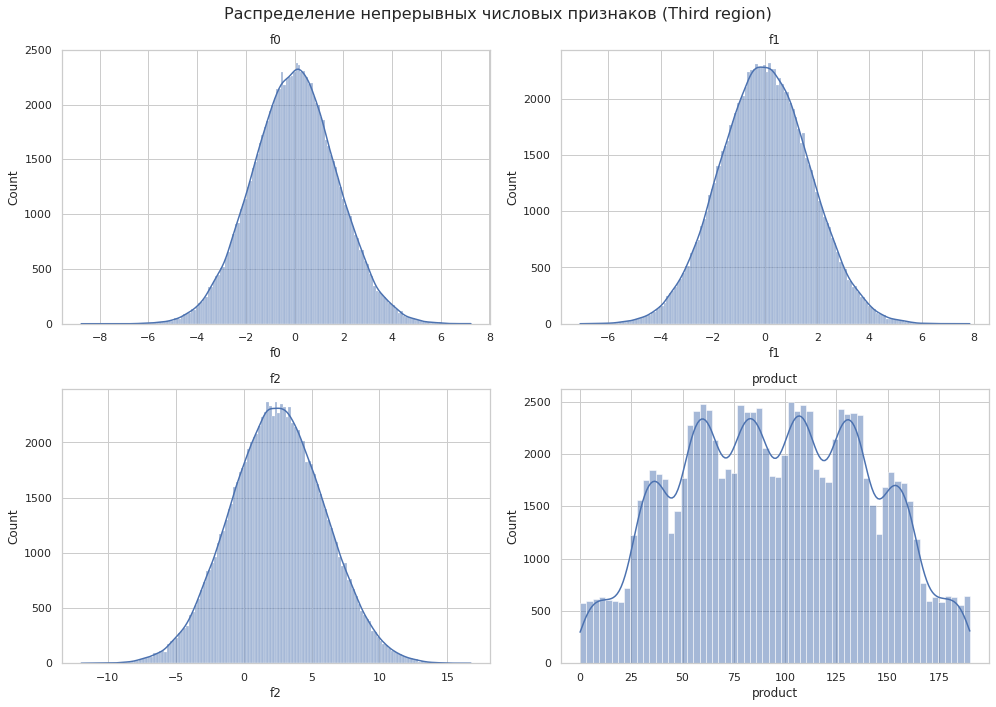

In [15]:
# Третий регион 
explore_dataframe(geo_data_2, "Third region")

Распределения всех признаков (`f0`, `f1`, `f2`) приближены к нормальному, симметричны и сбалансированы. Масштабы значений сопоставимы между собой и не содержат явных выбросов. Распределение целевой переменной аналогично первому региону – также наблюдается многомодальность, но без выраженной сегментации. Среднее значение `product` составляет 95.0 тыс. баррелей, что является наибольшим среди всех регионов.

Этот анализ показывает, что признаки в регионах распределены по-разному: регион 2 выделяется нестабильностью и дискретностью, в то время как регионы 1 и 3 обладают более предсказуемыми и плавными структурами. Это может повлиять на точность и устойчивость модели линейной регрессии, особенно в условиях ограничений по типу модели.

Во всех регионах признаки имеют разные масштабы: в регионе 2 значения `f0` и `f1` достигают ±30, тогда как в других регионах варьируются в пределах ±8 или меньше. Для обеспечения корректной работы линейной регрессии и сопоставимости весов модели рекомендуется провести стандартизацию признаков с помощью методов масштабирования, например `StandardScaler`. Это особенно важно при сравнении моделей между регионами и при использовании техники `Bootstrap`, где различие в шкалах может привести к искажению оценок.

### Оценка корреляций

In [16]:
# Тепловая карта корреляций между числовыми признаками
def plot_numeric_correlations(df, title='Корреляция числовых признаков'):
    df = df.drop(columns=['id'], errors='ignore')
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    corr = df[numeric_cols].corr(method='spearman')

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title(title)
    plt.tight_layout()
    plt.show()

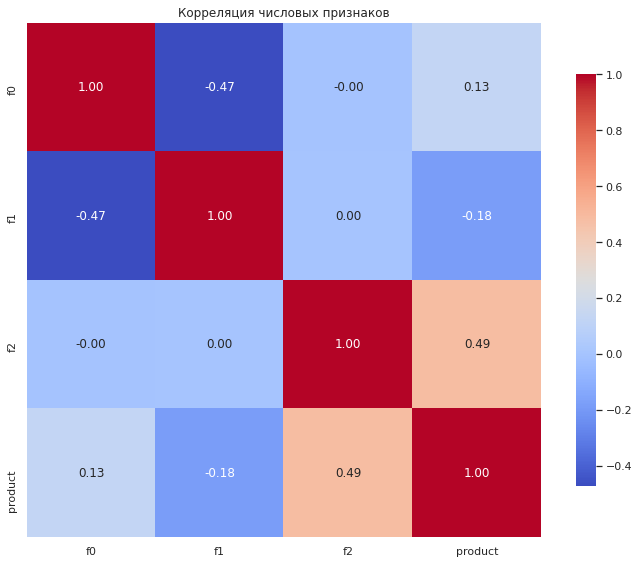

In [17]:
plot_numeric_correlations(geo_data_0)

В первом регионе умеренная положительная корреляция с целевой переменной наблюдается только у признака `f2` (0.49), тогда как `f0` и `f1` демонстрируют слабую связь с product (0.13 и -0.18 соответственно). Между признаками `f0` и `f1` присутствует отрицательная корреляция (-0.47), однако остальные пары практически некоррелированы. Наибольшую предсказательную ценность для модели имеет `f2`.

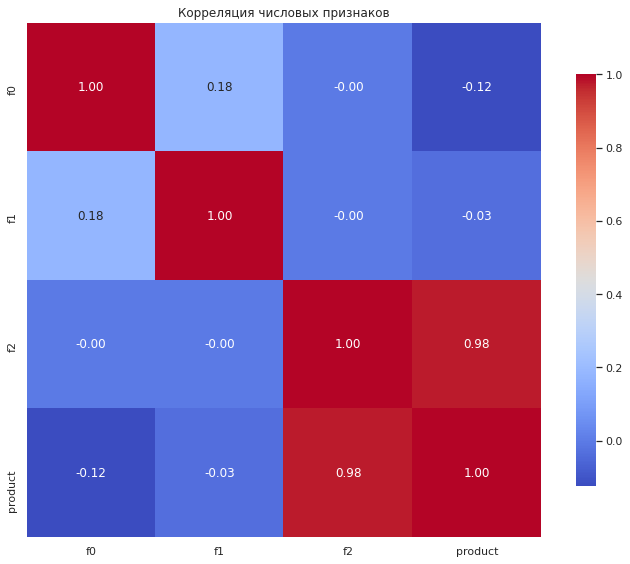

In [18]:
plot_numeric_correlations(geo_data_1)

Во втором регионе признак `f2` демонстрирует почти идеальную линейную корреляцию с целевой переменной (`product`, коэффициент 0.98), что указывает на прямое функциональное соответствие - вероятно, `product` вычисляется напрямую на основе `f2`. Остальные признаки (`f0` и `f1`) слабо связаны с целевой переменной. Модель линейной регрессии в этом регионе, по сути, будет опираться исключительно на `f2`.

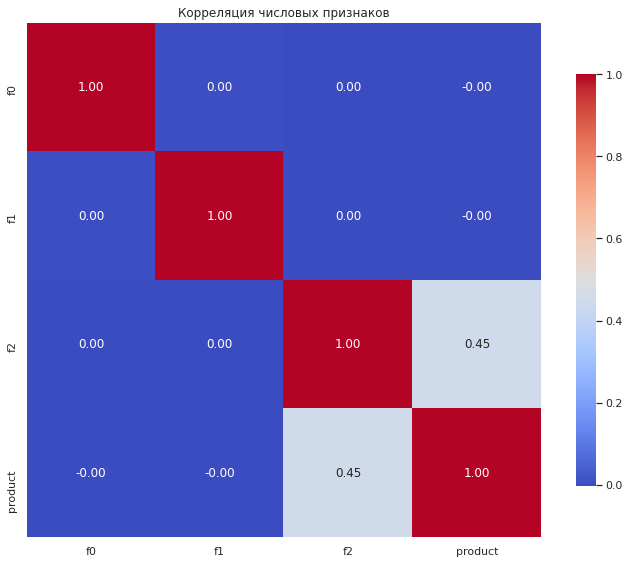

In [19]:
plot_numeric_correlations(geo_data_2)

В третьем регионе единственная заметная корреляция наблюдается между признаком `f2` и целевой переменной `product` (0.45), что делает `f2` основным источником информации для модели. Остальные признаки (`f0` и `f1`) не связаны ни с целевой переменной, ни друг с другом - все коэффициенты стремятся к нулю. Это указывает на потенциальную однофакторную зависимость объёма запасов от `f2`.

Во всех трёх регионах основным информативным признаком для предсказания объёма запасов (`product`) является `f2`, который демонстрирует умеренную или сильную положительную корреляцию (от 0.45 до 0.98). В регионах 1 и 3 значения корреляции достигают 0.49 и 0.45 соответственно, а во втором регионе наблюдается идеальная линейная зависимость между `f2` и целевым признаком, что может быть результатом синтетической генерации данных. Остальные признаки (`f0` и `f1`) либо слабо связаны с целевой переменной, либо полностью независимы. Между самими признаками значимой взаимной корреляции не обнаружено, за исключением умеренно отрицательной связи между `f0` и `f1` в первом регионе.

## Обучение и проверка модели

Для каждого региона подбирается лучшая линейная модель: без регуляризации, с L1 или L2-регуляризацией. Поиск осуществляется через `GridSearchCV` с подбором `alpha` и выбором между масштабированием и без него. Оцениваются основные метрики качества на валидационной выборке.

In [20]:
def train_with_full_cv(df, region_name="Регион", random_state=42):
    # Признаки и целевая переменная
    X = df.drop(columns=['id', 'product'])
    y = df['product']

    # Разделение на обучающую и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.25, random_state=random_state
    )

    # Список признаков
    num_features = X.columns.tolist()

    # Варианты масштабирования
    scalers = [StandardScaler(), 'passthrough']

    # Предобработка
    preprocessor = ColumnTransformer([
        ('num', 'passthrough', num_features)
    ])

    # Пайплайн
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())  # заглушка
    ])

    # Расширенная сетка параметров
    param_grid = [
        {
            'model': [Ridge(random_state=random_state), Lasso(random_state=random_state, max_iter=10000)],
            'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
            'preprocessor__num': scalers
        },
        {
            'model': [LinearRegression()],
            'preprocessor__num': scalers
        }
    ]

    # GridSearchCV
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)

    # Предсказания
    best_model = grid.best_estimator_
    preds = best_model.predict(X_valid)

    # Метрики
    mae = mean_absolute_error(y_valid, preds)
    mse = mean_squared_error(y_valid, preds)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    r2 = r2_score(y_valid, preds)
    mean_pred = preds.mean()

    # Вывод
    print(f"\n{region_name}:")
    print(f"Лучшая модель: {type(grid.best_estimator_.named_steps['model']).__name__}")
    if hasattr(grid.best_estimator_.named_steps['model'], 'alpha'):
        print(f"Альфа: {grid.best_estimator_.named_steps['model'].alpha}")
    print(f"Масштабирование: {type(grid.best_params_['preprocessor__num']).__name__ if grid.best_params_['preprocessor__num'] != 'passthrough' else 'без масштабирования'}")
    print(f"Среднее предсказание: {mean_pred:.2f} тыс. баррелей")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")

    return best_model, preds, y_valid.reset_index(drop=True)

In [21]:
model_r1, preds_r1, yval_r1 = train_with_full_cv(geo_data_0, "Region 1")


Region 1:
Лучшая модель: Ridge
Альфа: 10.0
Масштабирование: без масштабирования
Среднее предсказание: 92.40 тыс. баррелей
MAE: 31.05
MSE: 1425.56
RMSE: 37.76
R²: 0.2728


В первом регионе наилучшие результаты показала модель Ridge с высокой степенью регуляризации (`alpha = 10.0`) и без масштабирования. Среднее предсказание объёма запасов (92.40 тыс. баррелей) практически совпадает с фактическим средним, однако метрики качества свидетельствуют о невысокой точности модели: MAE составил 31.05, RMSE – 37.76, а коэффициент детерминации R² – лишь 0.27. Это указывает на слабую линейную предсказуемость целевой переменной и наличие существенной доли шума или нелинейных зависимостей в данных.

In [22]:
model_r2, preds_r2, yval_r2 = train_with_full_cv(geo_data_1, "Region 2")


Region 2:
Лучшая модель: Lasso
Альфа: 0.001
Масштабирование: без масштабирования
Среднее предсказание: 68.71 тыс. баррелей
MAE: 0.72
MSE: 0.79
RMSE: 0.89
R²: 0.9996


Во втором регионе лучшей оказалась модель Lasso с минимальным уровнем регуляризации (`alpha = 0.001`) и без масштабирования. Среднее предсказание (68.71 тыс. баррелей) почти совпадает с фактическим средним, а все метрики указывают на исключительно высокую точность: MAE – 0.72, RMSE – 0.89 и R² – 0.9996. Это подтверждает практически полную линейную зависимость целевой переменной от признаков, в первую очередь от `f2`, который, согласно корреляционному анализу, идеально соответствует `product`.

In [23]:
model_r3, preds_r3, yval_r3 = train_with_full_cv(geo_data_2, "Region 3")


Region 3:
Лучшая модель: Lasso
Альфа: 0.1
Масштабирование: StandardScaler
Среднее предсказание: 94.77 тыс. баррелей
MAE: 32.90
MSE: 1611.65
RMSE: 40.15
R²: 0.1964


В третьем регионе наилучший результат показала модель Lasso с умеренной регуляризацией (`alpha = 0.1`) и применением масштабирования признаков (`StandardScaler`). Среднее предсказание (94.77 тыс. баррелей) близко к фактическому значению, однако модель продемонстрировала слабое качество: MAE – 32.90, RMSE – 40.15, R² – 0.20. Это свидетельствует о низкой объясняющей способности линейной модели и наличии нерегулярных или нелинейных факторов, влияющих на объём запасов.

Для каждого региона была обучена линейная модель с автоматическим подбором регуляризации (L1/L2), параметра `alpha` и масштабирования признаков. Во втором регионе модель показала практически идеальное качество (R² ≈ 1.0), что подтверждает наличие явной линейной зависимости между признаками и целевой переменной. В первом и третьем регионах точность оказалась значительно ниже (R² менее 0.3), несмотря на настройку регуляризации и масштабирование. Это указывает на слабую линейную структуру данных и возможное влияние скрытых факторов. Таким образом, линейная модель подходит для региона 2, но недостаточно эффективна в регионах 1 и 3.

## Подготовка к расчёту прибыли

Сохраняем ключевые параметры:
- `BUDGET` = 10_000_000_000 – бюджет на разработку региона (в рублях);
- `PRICE_PER_BARREL` = 450_000 – доход за 1 тыс. баррелей (в рублях);
- `NUMBER_OF_WELLS` = 200 – количество скважин, которые будут разрабатываться;
- `SELECTED_WELLS` = 500 – количество скважин, из которых выбираются лучшие;
- `UNITS_TO_RUBLES` = 450_000 – коэффициент пересчёта запасов в прибыль.

Расчёт порогового объёма сырья:

$$
\text{Минимальный объём на скважину (в тыс. баррелей)} = \frac{\text{Бюджет}}{\text{Количество скважин} \times \text{Доход с 1 тыс. баррелей}}
$$

Сравним этот порог с **средним предсказанным значением `product`** по валидационной выборке для каждого региона (у нас оно уже есть).

In [24]:
# Параметры
BUDGET = 10_000_000_000  # рублей
PRICE_PER_BARREL = 450_000  # рублей за 1000 баррелей
NUMBER_OF_WELLS = 200
SELECTED_WELLS = 500

# Расчёт порогового объёма
min_product_threshold = BUDGET / (NUMBER_OF_WELLS * PRICE_PER_BARREL)
print(f"Минимальный объём сырья на одну скважину для безубыточности: {min_product_threshold:.2f} тыс. баррелей")

# Сравнение со средними фактическими значениями
print("Среднее фактическое значение product на валидационной выборке:")
print(f"Регион 1: {yval_r1.mean():.2f}")
print(f"Регион 2: {yval_r2.mean():.2f}")
print(f"Регион 3: {yval_r3.mean():.2f}")

Минимальный объём сырья на одну скважину для безубыточности: 111.11 тыс. баррелей
Среднее фактическое значение product на валидационной выборке:
Регион 1: 92.33
Регион 2: 68.73
Регион 3: 95.15


Для выхода на безубыточность каждая скважина должна содержать не менее 111.11 тыс. баррелей сырья. Средние объёмы по всем регионам ниже этой отметки: в регионе 1 - 92.33, в регионе 2 - 68.73, в регионе 3 - 95.15 тыс. баррелей. Это означает, что разработка всех скважин подряд в любом регионе приведёт к убыткам. Следовательно, для достижения прибыли необходимо выбирать только наиболее перспективные скважины с наибольшим предсказанным объёмом сырья.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- Выберем скважины с максимальными значениями предсказаний. 
- Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитаем прибыль для полученного объёма сырья.

In [31]:
def calculate_profit(predictions, targets, top_n=200, price_per_thousand_barrels=450_000, budget=10_000_000_000):
    # Индексы топ-N скважин по предсказаниям
    top_indices = predictions.argsort()[-top_n:]
    
    # Сумма фактического объёма сырья по этим скважинам
    selected_volume = targets.iloc[top_indices].sum()
    
    # Расчёт прибыли
    revenue = selected_volume * price_per_thousand_barrels
    profit = revenue - budget
    return profit

In [32]:
profit_r1 = calculate_profit(preds_r1, yval_r1)
profit_r2 = calculate_profit(preds_r2, yval_r2)
profit_r3 = calculate_profit(preds_r3, yval_r3)

print(f"Прибыль – Регион 1: {profit_r1:,.0f} руб.")
print(f"Прибыль – Регион 2: {profit_r2:,.0f} руб.")
print(f"Прибыль – Регион 3: {profit_r3:,.0f} руб.")

Прибыль – Регион 1: 3,359,141,114 руб.
Прибыль – Регион 2: 2,415,086,697 руб.
Прибыль – Регион 3: 2,583,442,208 руб.


На основании предсказаний модели и выбора 200 лучших скважин максимальная ожидаемая прибыль составляет 3.36 млрд рублей в регионе 1, 2.58 млрд в регионе 3 и 2.42 млрд в регионе 2. Таким образом, наибольшая потенциальная прибыль наблюдается в регионе 1, несмотря на то, что модель в этом регионе имеет сравнительно невысокое качество. Это объясняется наличием в выборке скважин с высокими фактическими объёмами сырья, что позволяет компенсировать ошибки модели при отборе.

Посчитаем риски и прибыль для каждого региона:
- Применим технику `Bootstrap` с 1000 выборок, чтобы найти распределение прибыли.
- Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.

In [39]:
def bootstrap_profit(predictions, targets, n_iterations=1000, sample_size=500, top_n=200, price_per_thousand_barrels=450_000, budget=10_000_000_000, seed=42):
    np.random.seed(seed)
    profits = []

    predictions = np.array(predictions)
    targets = np.array(targets)

    for _ in range(n_iterations):
        # Случайная выборка с заменой
        indices = np.random.choice(len(predictions), size=sample_size, replace=True)
        sample_preds = predictions[indices]
        sample_targets = targets[indices]

        # Выбор топ-N по предсказаниям
        top_indices = sample_preds.argsort()[-top_n:]
        selected_targets = sample_targets[top_indices]

        # Подсчёт прибыли
        revenue = selected_targets.sum() * price_per_thousand_barrels
        profit = revenue - budget
        profits.append(profit)

    profits = np.array(profits)
    mean_profit = profits.mean()
    lower = np.percentile(profits, 2.5)
    upper = np.percentile(profits, 97.5)
    risk = (profits < 0).mean()

    return mean_profit, (lower, upper), risk, profits

In [40]:
# Получение всех распределений
mean_r1, ci_r1, risk_r1, dist_r1 = bootstrap_profit(preds_r1, yval_r1)
mean_r2, ci_r2, risk_r2, dist_r2 = bootstrap_profit(preds_r2, yval_r2)
mean_r3, ci_r3, risk_r3, dist_r3 = bootstrap_profit(preds_r3, yval_r3)

# Вывод
print(f"Регион 1: Средняя прибыль = {mean_r1:,.0f}, 95% CI = ({ci_r1[0]:,.0f}, {ci_r1[1]:,.0f}), Риск убытка = {risk_r1:.2%}")
print(f"Регион 2: Средняя прибыль = {mean_r2:,.0f}, 95% CI = ({ci_r2[0]:,.0f}, {ci_r2[1]:,.0f}), Риск убытка = {risk_r2:.2%}")
print(f"Регион 3: Средняя прибыль = {mean_r3:,.0f}, 95% CI = ({ci_r3[0]:,.0f}, {ci_r3[1]:,.0f}), Риск убытка = {risk_r3:.2%}")

Регион 1: Средняя прибыль = 399,558,149, 95% CI = (-115,709,290, 897,460,328), Риск убытка = 6.00%
Регион 2: Средняя прибыль = 452,048,891, 95% CI = (61,684,480, 845,340,178), Риск убытка = 1.50%
Регион 3: Средняя прибыль = 375,121,866, 95% CI = (-140,788,056, 882,735,777), Риск убытка = 8.30%


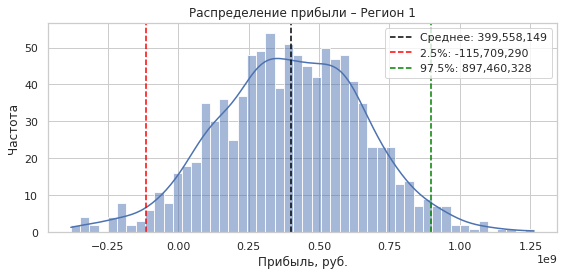

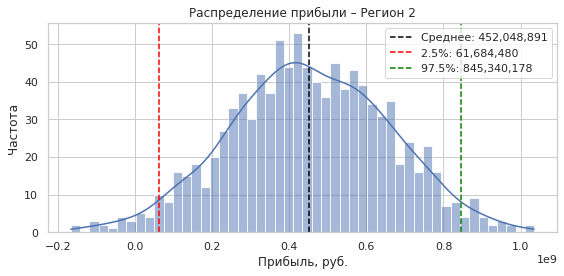

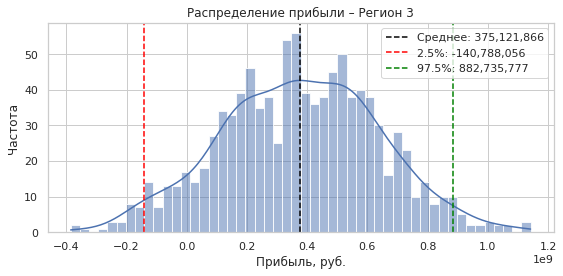

In [29]:
# Подготовка данных
bootstrap_data = {
    'Регион 1': dist_r1,
    'Регион 2': dist_r2,
    'Регион 3': dist_r3
}

# Построение графиков
for region, profits in bootstrap_data.items():
    mean = profits.mean()
    lower, upper = np.percentile(profits, [2.5, 97.5])

    plt.figure(figsize=(8, 4))
    sns.histplot(profits, bins=50, kde=True)
    plt.axvline(mean, color='black', linestyle='--', label=f'Среднее: {mean:,.0f}')
    plt.axvline(lower, color='red', linestyle='--', label=f'2.5%: {lower:,.0f}')
    plt.axvline(upper, color='green', linestyle='--', label=f'97.5%: {upper:,.0f}')
    plt.title(f'Распределение прибыли – {region}')
    plt.xlabel('Прибыль, руб.')
    plt.ylabel('Частота')
    plt.legend()
    plt.tight_layout()
    plt.show()

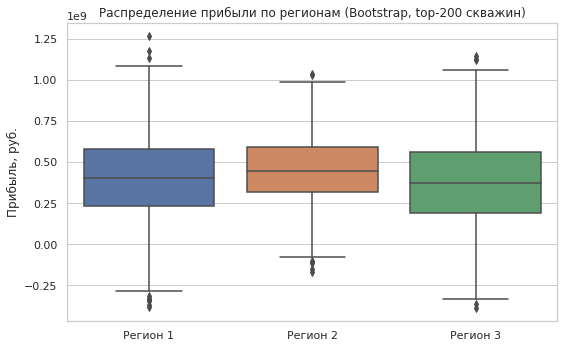

In [30]:
# Подготовка данных в DataFrame
df_box = pd.DataFrame({
    'Регион 1': dist_r1,
    'Регион 2': dist_r2,
    'Регион 3': dist_r3
})

# Преобразуем в длинный формат для seaborn
df_long = df_box.melt(var_name='Регион', value_name='Прибыль')

# Построение boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_long, x='Регион', y='Прибыль')
plt.title('Распределение прибыли по регионам (Bootstrap, top-200 скважин)')
plt.ylabel('Прибыль, руб.')
plt.xlabel('')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Согласно результатам бутстрэп-анализа с 1000 выборками, ни один из регионов не гарантирует стабильную прибыль при разработке 200 лучших скважин - во всех случаях существует риск убытков. Наиболее выгодным оказался регион 2: **средняя прибыль составляет 452 млн рублей**, доверительный интервал \[61.7 млн; 845.3 млн], а **риск убытков минимален - 1.5%**. В регионе 1 прибыль в среднем ниже (≈400 млн), а риск выше — 6%. В регионе 3 средняя прибыль наименьшая (≈375 млн), при этом вероятность убытков достигает 8.3%.

Визуальный анализ распределений прибылей (гистограммы и boxplot) показывает, что оценки для всех регионов варьируются существенно, с наличием выбросов и асимметрии. Тем не менее, **регион 2 демонстрирует наилучший баланс между доходностью и надёжностью**.

**Рекомендуется выбрать регион 2 для разработки**, поскольку он обеспечивает **самую высокую среднюю прибыль при минимальном уровне риска**.